In [ ]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


与LSTM.inynb的区别就是这里不再划分训练集和测试集合，所有的数据都是训练集

In [ ]:
# with open("/content/drive/MyDrive/covid/data/data_table_for_daily_case_trends__the_united_states.csv", "r", encoding="utf-8") as f:
#     data = f.read()

# data = [row.split(',') for row in  data.split("\n")]

# # value = [int(each[1]) for each in data]
# value = [float(each[2]) for each in data[1:]]

import csv
value = []
with open("/content/drive/MyDrive/covid/data/new_york_(excludes_nyc).csv", "r", encoding="utf-8") as f:
    csv_reader = csv.reader(f, delimiter=',')
    headers = next(csv_reader)
    for i in csv_reader:
        value.append(int(i[2]))

value.reverse()

seq = 7

# 训练集构造

li_x = []
li_y = []

for i in range(len(value) - seq):
    # 输入就是[x, x+1, x+2, ... , x + (seq-1)]天的数据，输出是 x + seq 天的数据
    li_x.append(value[i: i+seq])
    li_y.append(value[i+seq])



train_x = (torch.tensor(li_x).float() / 1000.).reshape(-1, seq, 1).to(device)
train_y = (torch.tensor(li_y).float() / 1000.).reshape(-1, 1).to(device)




In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
        # 输入格式是1，输出隐藏层大小是32
        # 对于小数据集num_layers不要设置大，否则会因为模型变复杂而导致效果会变差
        # num_layers顾名思义就是有几个lstm层，假如设置成2，就相当于连续经过两个lstm层
        # 原来的输入格式是：(seq, batch, shape)
        # 设置batch_first=True以后，输入格式就可以改为：(batch, seq, shape)，更符合平常使用的习惯
        self.linear = nn.Linear(32*seq, 1)

    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = x.reshape(-1, 32*seq)
        x = self.linear(x)
        return x

In [ ]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

In [ ]:
model.train()
for epoch in range(3000):
    output = model(train_x)
    loss = loss_fun(output, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0 and epoch > 0:
        print("epoch:{}, loss:{}".format(epoch, loss))


epoch:20, loss:33.613075256347656
epoch:40, loss:22.508180618286133
epoch:60, loss:16.48678207397461
epoch:80, loss:11.997509002685547
epoch:100, loss:8.937207221984863
epoch:120, loss:7.04880428314209
epoch:140, loss:5.840900897979736
epoch:160, loss:5.138308048248291
epoch:180, loss:4.703380107879639
epoch:200, loss:4.375041484832764
epoch:220, loss:4.084005832672119
epoch:240, loss:3.8034770488739014
epoch:260, loss:3.5614354610443115
epoch:280, loss:3.3600473403930664
epoch:300, loss:3.2016377449035645
epoch:320, loss:3.0784912109375
epoch:340, loss:2.9768640995025635
epoch:360, loss:2.8901848793029785
epoch:380, loss:2.8163373470306396
epoch:400, loss:2.7499988079071045
epoch:420, loss:2.687676429748535
epoch:440, loss:2.626519203186035
epoch:460, loss:2.562863349914551
epoch:480, loss:2.4966444969177246
epoch:500, loss:2.431596279144287
epoch:520, loss:2.3685364723205566
epoch:540, loss:2.3057026863098145
epoch:560, loss:2.2420153617858887
epoch:580, loss:2.1771469116210938
epoch

绘制训练效果图

MSE: 127425.234


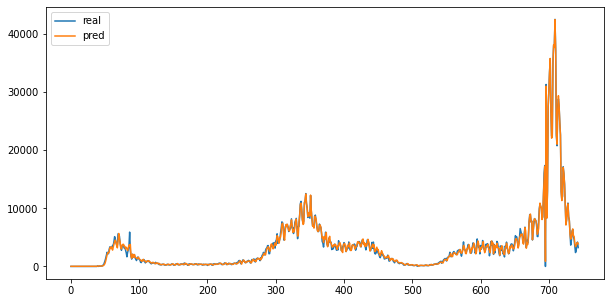

In [ ]:
model.eval()

train_pre = list((model(train_x).data.reshape(-1))*1000)

from sklearn.metrics import mean_squared_error
print("MSE:", mean_squared_error(train_y*1000, train_pre))


plt.figure(figsize=(10,5))

# 真实数据
plt.plot(train_y*1000, label="real")


# 预测结果
plt.plot(train_pre, label="pred")

# 模型预测的走势
plt.legend(loc='best')
plt.savefig('fig1.png', dpi = 300)

In [ ]:
result = []

# 使用训练集最后七天的数据作为起始点
print(len(train_x))

result.append(train_x[743][0][0])
result.append(train_x[743][1][0])
result.append(train_x[743][2][0])
result.append(train_x[743][3][0])
result.append(train_x[743][4][0])
result.append(train_x[743][5][0])
result.append(train_x[743][6][0])


print(result)

744
[tensor(5.1270), tensor(4.6680), tensor(3.5060), tensor(2.3900), tensor(2.6390), tensor(4.0340), tensor(4.1880)]


107
107


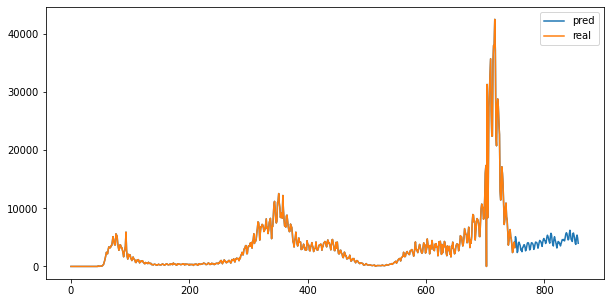

In [ ]:
# 预测未来30天的数据，
for i in range(100):
  result.append(model(torch.tensor(result[i:i+7]).reshape(1,7,1)))

print(len(result)) 



results =  value + [i * 1000 for i in result]
print(len(result))



plt.figure(figsize=(10,5))

# 预测结果
plt.plot(results, label="pred")

# 真实数据
plt.plot(value, label="real")


# 模型预测的走势
plt.legend(loc='best')
plt.savefig('fig2.png', dpi = 300)